# 02 - Validación y evaluación de variables simuladas  

Este cuaderno sirve como apoyo a la validación y evaluación de variables simuladas, permitiendo evaluar la variable establecida (normalización o modelo Ineichen-Perez por defecto) que se defina como `sim_irradiance` en la sección "Definición de variable evaluada". 

## 1. Importación de librerías y configuración inicial

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Configuration Parameters
ARCHIVO_CSV = '../data/dataset_master_tfg.csv'
FECHA_OBJETIVO = '2025-10-07'  # YYYY-MM-DD
SENSOR_OBJETIVO = 'P1'         # Sensor name (P0, P1, P4, Pinc, etc.)
BASELINE = 0                   # 0 = Normalization. 1 = Ineichen-Perez Clear-Sky 

# Data Loading
df = pd.read_csv(ARCHIVO_CSV, index_col=0, parse_dates=True)
df.index.name = 'timestamp'

## 2. Definición de variable a evaluar

In [3]:
if BASELINE == 0:  
    #--- SIMULATION ---
    df['sim_irradiance'] = (
        0.002401 * df['sim_comp_direct_lux'] + 
        5.03e-8  * df['sim_comp_direct_lux']**2 + 
        0.01305  * df['sim_comp_amb_lux']
    ).clip(lower=0)
    
else:
    # --- CLEAR-SKY ---
    df['sim_irradiance'] = df['sim_cs_ghi']

## 3. Evaluación

--- RESULTADOS: P1 | 2025-10-07 ---
R² (Determinación): 0.9833
MAE (Error Medio Absoluto): 28.1388 W/m²
RMSE (Error Cuadrático Medio): 35.8199 W/m²


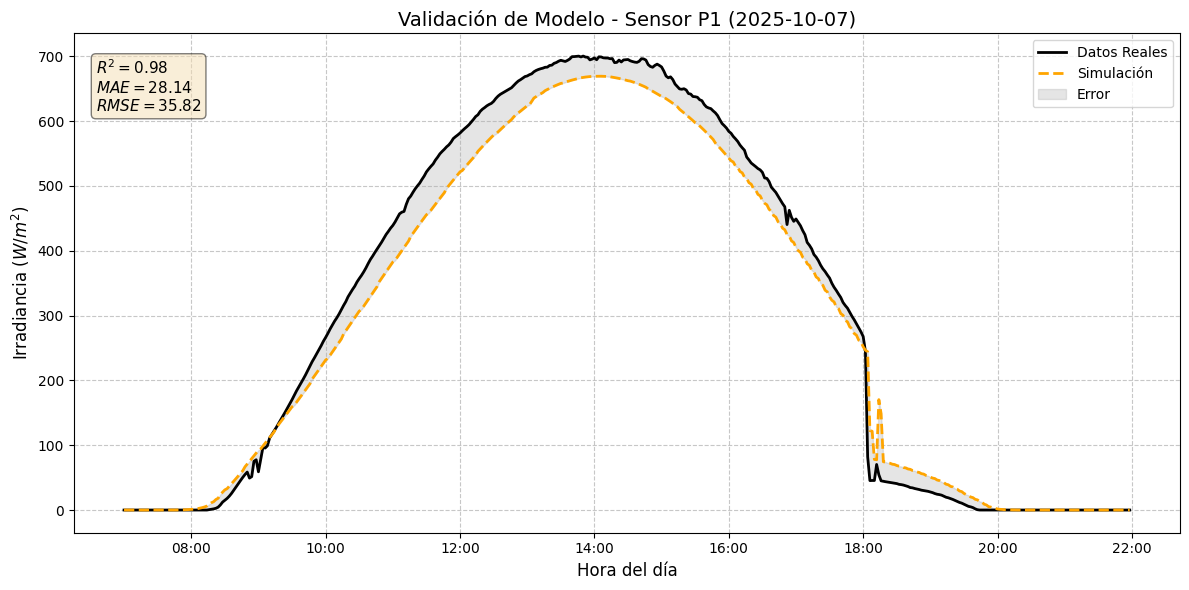

In [4]:
# Compute
mask = (df['sensor'] == SENSOR_OBJETIVO) & (df['date'] == FECHA_OBJETIVO)
df_filtered = df[mask].copy()
df_filtered = df_filtered.dropna(subset=['real_irradiance', 'sim_irradiance'])

if df_filtered.empty:
    print(f"Error: No se encontraron datos para el sensor {SENSOR_OBJETIVO} en la fecha {FECHA_OBJETIVO}.")
else:
    y_real = df_filtered['real_irradiance']
    y_sim = df_filtered['sim_irradiance']

    r2 = r2_score(y_real, y_sim)
    mae = mean_absolute_error(y_real, y_sim)
    rmse = np.sqrt(mean_squared_error(y_real, y_sim))

    print(f"--- RESULTADOS: {SENSOR_OBJETIVO} | {FECHA_OBJETIVO} ---")
    print(f"R² (Determinación): {r2:.4f}")
    print(f"MAE (Error Medio Absoluto): {mae:.4f} W/m²")
    print(f"RMSE (Error Cuadrático Medio): {rmse:.4f} W/m²")

    # ---------------------------------------------------------
    #    PLOT
    # ---------------------------------------------------------
    plt.figure(figsize=(12, 6))
    
    plt.plot(df_filtered.index, y_real, label='Datos Reales', color='black', linewidth=2)
    plt.plot(df_filtered.index, y_sim, label='Simulación', color='orange', linestyle='--', linewidth=2)
    
    plt.fill_between(df_filtered.index, y_real, y_sim, color='gray', alpha=0.2, label='Error')

    plt.title(f'Validación de Modelo - Sensor {SENSOR_OBJETIVO} ({FECHA_OBJETIVO})', fontsize=14)
    plt.ylabel('Irradiancia ($W/m^2$)', fontsize=12)
    plt.xlabel('Hora del día', fontsize=12)
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    stats_text = '\n'.join((
        f'$R^2 = {r2:.2f}$',
        f'$MAE = {mae:.2f}$',
        f'$RMSE = {rmse:.2f}$'))
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.gca().text(0.02, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=11,
            verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.show()
